<a href="https://colab.research.google.com/github/ianwolf99/Advanced-AI-Stock-Predictor/blob/main/3_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 51kB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 419kB 11.5MB/s 
    100% |████████████████████████████████| 3.0MB 5.7MB/s 


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

Date     Open     High      Low    Close  Adj Close  Volume
0 2010-07-16  0.04951  0.04951  0.04951  0.04951    0.04951       0
1 2010-07-17  0.04951  0.08585  0.05941  0.08584    0.08584       5
2 2010-07-18  0.08584  0.09307  0.07723  0.08080    0.08080      49
3 2010-07-19  0.08080  0.08181  0.07426  0.07474    0.07474      20
4 2010-07-20  0.07474  0.07921  0.06634  0.07921    0.07921      42

In [ ]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

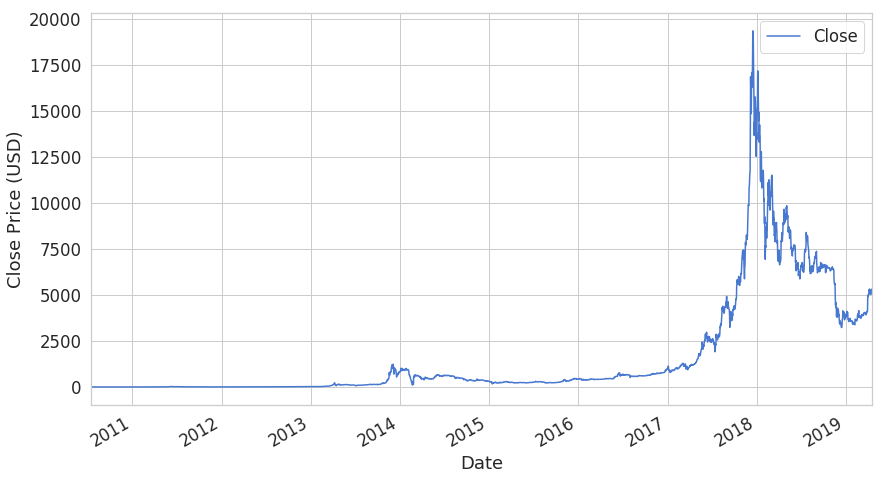

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(3201, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(2945, 99, 1)

In [ ]:
X_test.shape

(156, 99, 1)

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Train on 2650 samples, validate on 295 samples
Epoch 1/50
2650/2650 [==============================] - 11s 4ms/sample - loss: 0.0011 - val_loss: 0.0542
Epoch 2/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0075 - val_loss: 0.0042
Epoch 3/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0110 - val_loss: 0.0217
Epoch 4/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0058 - val_loss: 0.0028
Epoch 5/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0142 - val_loss: 0.0567
Epoch 6/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0061 - val_loss: 0.0023
Epoch 7/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0123 - val_loss: 0.0425
Epoch 8/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0092 - val_loss: 0.0111
Epoch 9/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0257 - val_loss: 0.0466
Epoch 10/50
2650

In [ ]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 0s 1ms/sample - loss: 0.0016


0.0015700155860171295

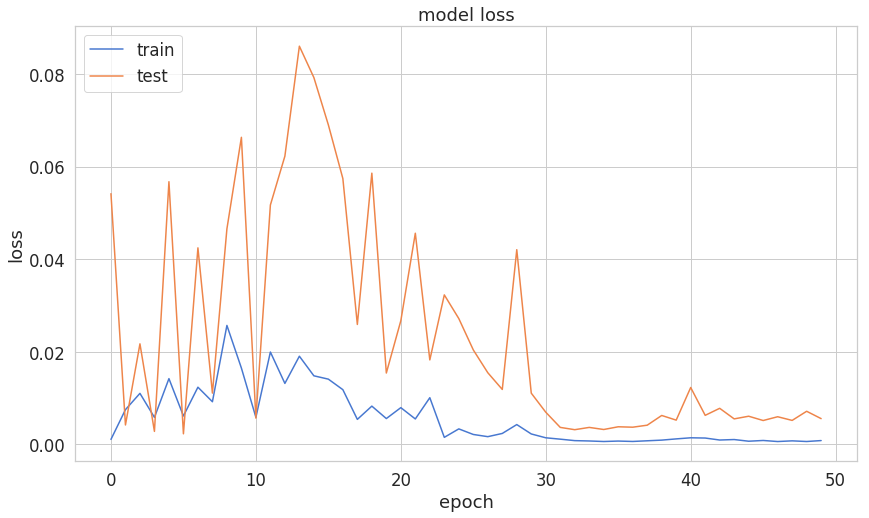

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

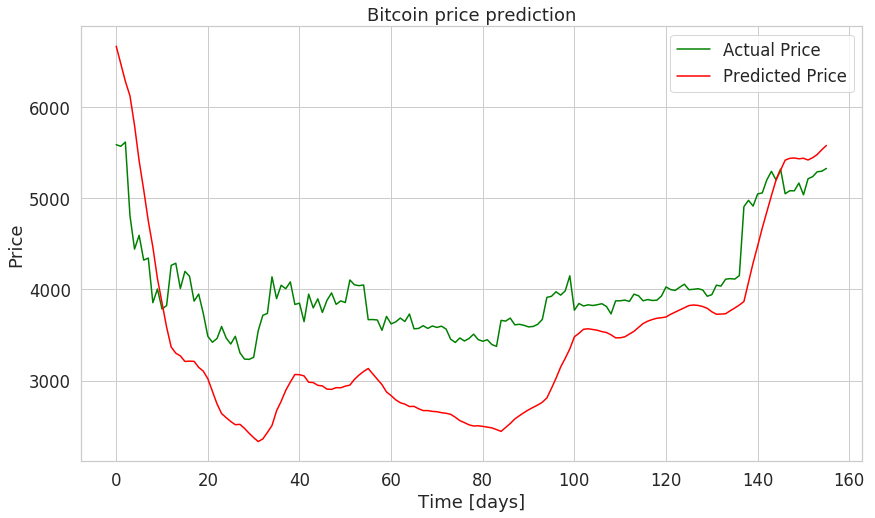

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();